# DCGAN

DCGANでただ絵文字を学習させるだけ

In [75]:
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset

import matplotlib.pyplot as plt
from IPython.display import display
from tqdm import tqdm

## network

In [82]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.convT(100, 512, 4, 1, 0), # ( 4,  4)
            self.convT(512, 256, 4, 2, 1), # ( 8,  8)
            self.convT(256, 128, 4, 2, 1), # (16, 16)
            self.convT(128,  64, 4, 2, 1), # (32, 32)
            nn.ConvTranspose2d(64, 3, 4, 2, 1), # (64, 64)
            nn.Sigmoid()
        )

    def convT(self, in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
        return net

    def forward(self, x):
        y = self.net(x)
        return y

In [83]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            self.conv(   3,   64, 4, 2, 1), # (32, 32)
            self.conv(  64,  128, 4, 2, 1), # (16, 16)
            self.conv( 128,  256, 4, 2, 1), # ( 8,  8)
            self.conv( 256,  512, 4, 2, 1), # ( 4,  4)
            self.conv( 512, 1024, 4, 2, 1), # ( 2,  2)
            nn.Conv2d(1024,    1, 4, 2, 1), # ( 1,  1)
            nn.Flatten(),
            nn.Sigmoid()
        )

    def conv(self, in_channels, out_channels, kernel_size, stride, padding):
        net = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU()
        )
        return net

    def forward(self, x):
        y = self.net(x)
        return y

## dataset

In [58]:
from images_transpose import to_tensor

torch.Size([3670, 3, 64, 64])
<examples>


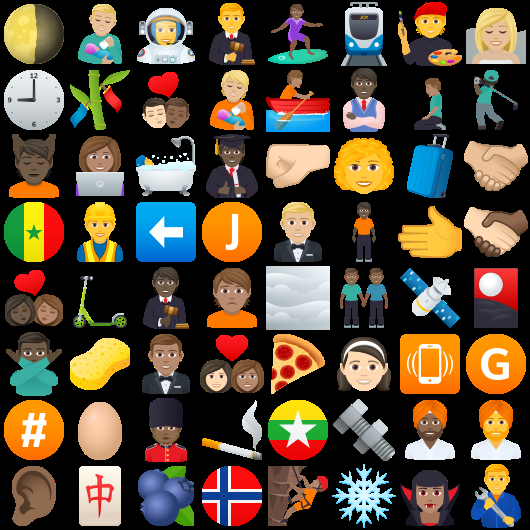

In [112]:
data = to_tensor('data/images/')
print(data.shape)

img = torchvision.utils.make_grid(data[:64], nrow=8)
img = transforms.functional.to_pil_image(img)
print('<examples>')
display(img)

data = data / 255.

In [80]:
batch_size = 64

dataset = TensorDataset(data, torch.zeros(data.shape[0]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

## train

In [123]:
batch_size = 64
device = 'cuda'
netD = Discriminator().to(device)
netG = Generator().to(device)
optimD = optim.Adam(netD.parameters(), lr=0.0002)
optimG = optim.Adam(netG.parameters(), lr=0.0002)

In [125]:
def write(nrow=6, nimages_per_row=10):
    noizes = torch.randn(nimages_per_row * nrow, 100, 1, 1).to(device)
    img = netG(noizes)
    img = img.cpu().detach()
    img = torchvision.utils.make_grid(img, nrow=nimages_per_row)
    img = transforms.functional.to_pil_image(img)
    display(img)

In [127]:
def train(n_epochs, print_interval=10):
    netD.train()
    netG.train()
    BCE = nn.BCELoss()

    for n in range(1, n_epochs+1):
        for images, _ in dataloader:
            batch_size = len(images)
            label_real = torch.ones((batch_size, 1)).to(device)
            label_fake = torch.zeros((batch_size, 1)).to(device)
            images = images.to(device)
            optimD.zero_grad()
            optimG.zero_grad()

            # fake image generate
            noizes = torch.randn(len(images), 100, 1, 1).to(device)
            fake = netG(noizes)

            # train discriminator
            pred_fake = netD(fake)
            pred_real = netD(images)
            lossD_fake = BCE(pred_fake, label_fake)
            lossD_real = BCE(pred_real, label_real)
            lossD = lossD_fake + lossD_real
            lossD.backward(retain_graph=True)
            optimD.step()

            # train generator
            pred = netD(fake)
            lossG = BCE(pred, label_real)
            lossG.backward(retain_graph=True)
            optimG.step()

        if not n % print_interval:
            print(f'{n:>4}epoch lossD: {lossD.item()} lossG: {lossG.item()}')
            write(1)

  20epoch lossD: 0.0022068493999540806 lossG: 11.891921997070312


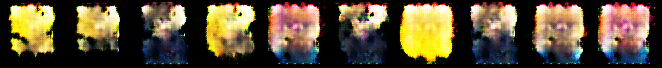

  40epoch lossD: 0.008870569057762623 lossG: 5.73141622543335


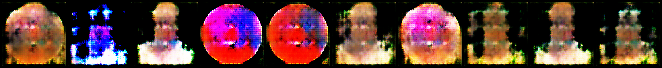

  60epoch lossD: 0.031685102730989456 lossG: 4.925692081451416


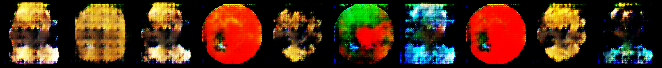

  80epoch lossD: 0.16238272190093994 lossG: 4.855088233947754


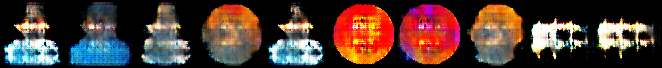

 100epoch lossD: 0.02219283953309059 lossG: 6.574291706085205


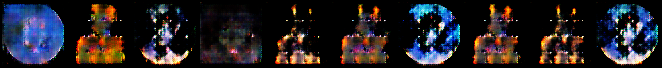

 120epoch lossD: 4.000541230197996e-05 lossG: 14.569777488708496


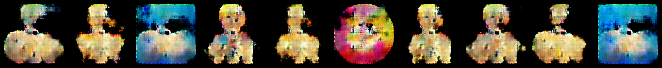

 140epoch lossD: 0.0008698035962879658 lossG: 11.533272743225098


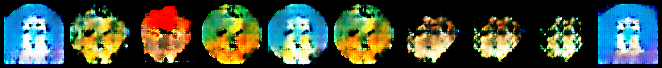

 160epoch lossD: 0.5024820566177368 lossG: 21.539091110229492


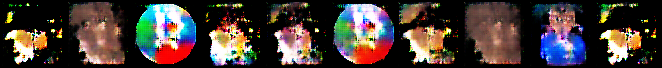

 180epoch lossD: 0.00023082943516783416 lossG: 9.29299545288086


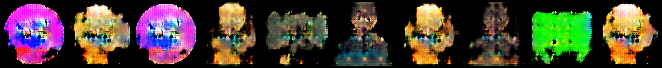

 200epoch lossD: 0.0004818722081836313 lossG: 8.622739791870117


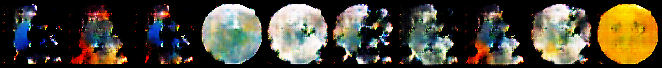

 220epoch lossD: 0.007095430511981249 lossG: 5.944608688354492


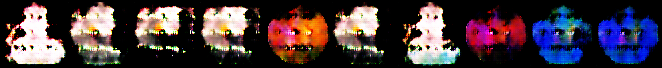

 240epoch lossD: 0.05107642710208893 lossG: 14.844327926635742


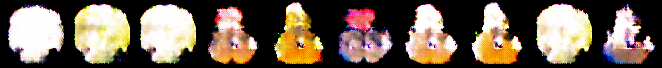

 260epoch lossD: 0.00027988379588350654 lossG: 15.968234062194824


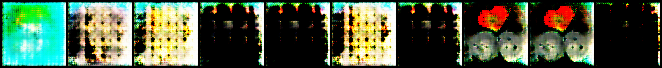

 280epoch lossD: 0.009195651859045029 lossG: 8.979059219360352


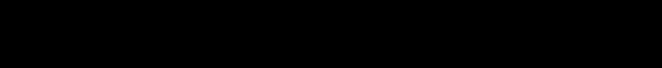

 300epoch lossD: 3.537117299856618e-05 lossG: 12.37328052520752


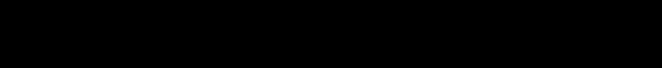

 320epoch lossD: 7.786587957525626e-06 lossG: 13.931804656982422


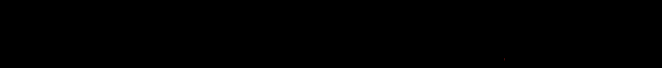

 340epoch lossD: 3.392086682652007e-06 lossG: 29.791316986083984


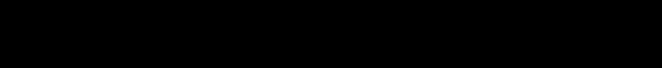

 360epoch lossD: 5.819686066388385e-06 lossG: 23.230825424194336


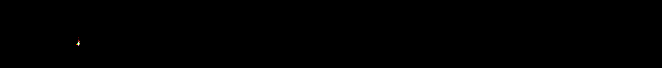

 380epoch lossD: 2.1972559807181824e-06 lossG: 17.172332763671875


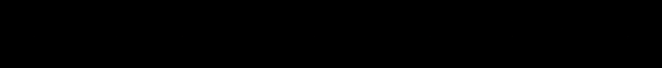

 400epoch lossD: 7.802805157552939e-07 lossG: 23.75601577758789


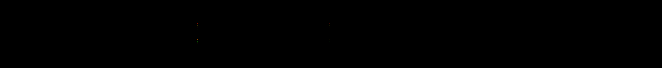

 420epoch lossD: 1.6797682178548712e-07 lossG: 21.176128387451172


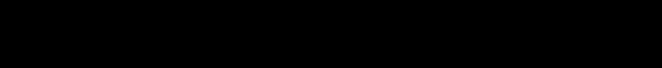

KeyboardInterrupt: 

In [130]:
train(500, print_interval=20)

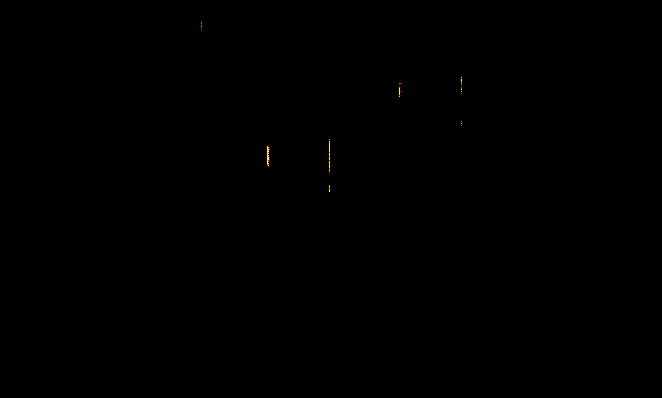

In [131]:
write()

Discriminatorがちょっと強かったかな